In [33]:
from Iris_recognition import *
from Periocular_recognition import *
import os

In [34]:
fold_num = 4

In [35]:
def create_dataset(img_folder, fold):

    test_data=[]
    test_label=[]
    fold_list=[i for i in range((fold-1)*2, fold*2)]
   
    for dir1 in tqdm(os.listdir(img_folder)):
        for eye in os.listdir(os.path.join(img_folder, dir1)):
            for file in list(os.listdir(os.path.join(img_folder, dir1, eye))[i] for i in fold_list): # 2 4 6 8
                image_path= os.path.join(img_folder, dir1, eye, file)
                if image_path.endswith(".jpg") == False:
                    continue
                img = image.load_img(image_path, target_size=(64, 64))
                img = image.img_to_array(img)
                test_data.append(img)
                test_label.append(dir1+'0' if eye == 'L' else dir1+'1')
    
    np.save(f'temp_data/5fold/Fusion_x_fold{fold}.npy', test_data)
    np.save(f'temp_data/5fold/Fusion_y_fold{fold}.npy', test_label)         
    return np.array(test_data), np.array(test_label)

In [36]:
X_test, y_test = create_dataset('Iris-Dataset/CASIA-Iris-Thousand', fold_num)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
def load_dataset(fold):
    Fusion_X, Fusion_y = combine_LR(np.load(f'temp_data/5fold/Fusion_x_fold{fold}.npy'), 
                                    np.load(f'temp_data/5fold/Fusion_y_fold{fold}.npy'), 
                                    1000, 2)
    
    model = VGG16(weights='imagenet', include_top=False,
                  input_shape=(64, 128, 3))
    with tf.device('GPU:0'):
        features_test = model.predict(Fusion_X)

    return features_test, Fusion_X, Fusion_y

In [38]:
features_test, Fusion_X, Fusion_y = load_dataset(fold_num)

63/63 [==============================] - 2s 23ms/step


In [39]:
iris_norm_L = np.load('temp_data/iris_norm_L_all.npy')
iris_norm_R = np.load('temp_data/iris_norm_R_all.npy')

def create_fold_norm(fold):
    iris_norm_L_fold = []
    iris_norm_R_fold = []
    for fol in range(1000):
        for item in range(4):
            iris_norm_L_fold.append(iris_norm_L[fol*10+item+fold])
            iris_norm_R_fold.append(iris_norm_R[fol*10+item+fold])
    return np.array(iris_norm_L_fold), np.array(iris_norm_R_fold)

In [40]:
iris_norm_L_fold, iris_norm_R_fold = create_fold_norm(fold_num-1)

In [41]:
import concurrent.futures
from functools import partial
from itertools import product

In [42]:
def accuracy_score_multi_thread(ref_num, test_num, same_num=2):
    # Load dataset
    # features_test, Fusion_X, Fusion_y = load_dataset()

    # Define function to process image pairs
    def process_images(args):
        img_1_fol, img_1_item, img_2_fol, img_2_item = args
        tar = 0
        trr = 0
        far = 0
        frr = 0
        total_test_img = 2
        predict = []
        ground_truth = []

        # Determine ground truth label
        if img_1_fol == img_2_fol:
            ground_truth.append(1)
        else:
            ground_truth.append(0)

        # Load iris images and compute iris match score
        img_1_L = iris_norm_L_fold[(img_1_fol) * total_test_img + img_1_item]
        img_1_R = iris_norm_R_fold[(img_1_fol) * total_test_img + img_1_item]
        img_2_L = iris_norm_L_fold[(img_2_fol) * total_test_img + img_2_item]
        img_2_R = iris_norm_R_fold[(img_2_fol) * total_test_img + img_2_item]
        iris_score = iris_match_preload(img_1_L, img_1_R, img_2_L, img_2_R)

        # If iris match score is "Match", predict a match and update statistics
        if iris_score == "Match":
            predict.append(1)
            if img_2_fol == img_1_fol:
                tar += 1
            else:
                far += 1
        # If iris match score is "Not Sure" or "No Iris", predict using periocular features and update statistics
        elif iris_score == "Not Sure" or iris_score == "No Iris":
            peri_score = predict_image(features_test, str(img_1_fol).zfill(3), img_2_item + total_test_img * img_2_fol, fold_num)
            if peri_score == "Match":
                predict.append(1)
                if img_2_fol == img_1_fol:
                    tar += 1
                else:
                    far += 1
            else:
                predict.append(0)
                if img_2_fol == img_1_fol:
                    frr += 1
                else:
                    trr += 1
        # If iris match score is "No Match", predict a non-match and update statistics
        else:
            predict.append(0)
            if img_2_fol == img_1_fol:
                frr += 1
            else:
                trr += 1

        return tar, trr, far, frr, predict, ground_truth

    # Initialize statistics and prediction/ground truth lists
    tar = 0
    trr = 0
    far = 0
    frr = 0
    predict = []
    ground_truth = []
    
    # Use ThreadPoolExecutor to process image pairs in parallel
    max_workers = 2 * os.cpu_count()
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_combinations = product(
            range(ref_num), range(0,1), range(test_num), range(1,same_num)
        )
        for t, true, f, false, p, g in tqdm(executor.map(process_images, image_combinations), total=ref_num*test_num*(same_num-1)):
            tar += t
            trr += true
            far += f
            frr += false
            predict.extend(p)
            ground_truth.extend(g)

    # Compute and return confusion matrix and prediction/ground truth lists
    return [[trr, far], [frr, tar]], predict, ground_truth

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [44]:
def plot_confu(ground_truth, predict):
    # compute the confusion matrix
    cm = confusion_matrix(ground_truth, predict)

    # plot the confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), horizontalalignment="center", color="white" if cm[i,j] > cm.max() / 2 else "black")

    plt.show()

In [45]:
def print_accuracy(ground_truth, confu):
    # calculate the true acceptance rate (TAR), true rejection rate (TRR), false acceptance rate (FAR), and false rejection rate (FRR)
    total_positive = np.sum(ground_truth)
    total_negative = len(ground_truth) - total_positive
    confu = np.array(confu)
    true_positive = confu[1, 1]
    true_negative = confu[0, 0]
    false_positive = confu[0, 1]
    false_negative = confu[1, 0]

    tar = true_positive / total_positive
    trr = true_negative / total_negative
    far = false_positive / total_negative
    frr = false_negative / total_positive
    # print the accuracy and error rates
    accuracy = (true_positive + true_negative) / len(ground_truth)
    error_rate = 1 - accuracy
    print(f'True Acceptance Rate (TAR): {tar*100}%')
    print(f'True Rejection Rate (TRR): {trr*100}%')
    print(f'False Acceptance Rate (FAR): {far*100}%')
    print(f'False Rejection Rate (FRR): {frr*100}%')
    print(f'Accuracy: {accuracy*100}%')
    print(f'Error Rate: {error_rate*100}%')
    # print(f'Recongition Rate: {(1-far-frr)*100}%')
    # print(f'Error: {(far+frr)*100}%')

In [49]:
confu, predict, ground_truth = accuracy_score_multi_thread(200, 200, 2)

  0%|          | 0/40000 [00:00<?, ?it/s]

c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  


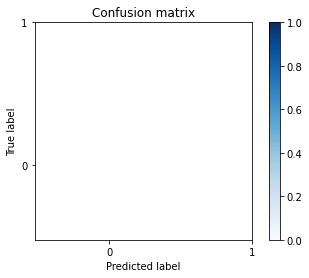

In [47]:
plot_confu(ground_truth, predict)

In [48]:
print_accuracy(ground_truth, confu)

True Acceptance Rate (TAR): nan%
True Rejection Rate (TRR): nan%
False Acceptance Rate (FAR): nan%
False Rejection Rate (FRR): nan%
Accuracy: nan%
Error Rate: nan%


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
